In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
from datetime import datetime
import os
import torch
from pkg import DEVICE
from models._utils import *
from visualize._utils import plot_heat_map
from utils import NEURONS_302
from scipy import stats

/om2/user/lrvenan/miniconda/envs/worm-graph/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


# Prediction
---

In [19]:
url = '/home/lrvnc/Projects/worm-graph/logs/hydra/2023_08_11_18_21_44/prediction/val/worm0.csv'
df = pd.read_csv(url)
df.set_index(['Type', 'Unnamed: 1'], inplace=True)
df.index.names = ['Type', '']
df

ADAL  ADAR      ADEL  ADER      ADFL  ADFR  ADLL      ADLR  \
Type                                                                          
Context      0    0.0   0.0 -0.594904   0.0  0.384806   0.0   0.0 -0.114242   
             1    0.0   0.0 -0.585627   0.0  0.331915   0.0   0.0 -0.107379   
             2    0.0   0.0 -0.584745   0.0  0.278769   0.0   0.0 -0.104845   
             3    0.0   0.0 -0.591304   0.0  0.228208   0.0   0.0 -0.109226   
             4    0.0   0.0 -0.603119   0.0  0.178646   0.0   0.0 -0.122639   
...               ...   ...       ...   ...       ...   ...   ...       ...   
Ground Truth 55   0.0   0.0 -0.177163   0.0 -0.394169   0.0   0.0 -0.660681   
             56   0.0   0.0 -0.161651   0.0 -0.391279   0.0   0.0 -0.660817   
             57   0.0   0.0 -0.151877   0.0 -0.364257   0.0   0.0 -0.654719   
             58   0.0   0.0 -0.153807   0.0 -0.316537   0.0   0.0 -0.645049   
             59   0.0   0.0 -0.170995   0.0 -0.254996   0.0   0.0 -0.635169   

                     AFDL  AFDR  ...      VD12  VD13  VD2  VD3  VD4  VD5  VD6  \
Type                             ...                                            
Context      0   0.043545   0.0  ...  0.754414   0.0  0.0  0.0  0.0  0.0  0.0   
             1   0.263606   0.0  ...  0.770556   0.0  0.0  0.0  0.0  0.0  0.0   
             2   0.435841   0.0  ...  0.759541   0.0  0.0  0.0  0.0  0.0  0.0   
             3   0.535645   0.0  ...  0.713067   0.0  0.0  0.0  0.0  0.0  0.0   
             4   0.549146   0.0  ...  0.627688   0.0  0.0  0.0  0.0  0.0  0.0   
...                   ...   ...  ...       ...   ...  ...  ...  ...  ...  ...   
Ground Truth 55  0.959838   0.0  ...  0.342567   0.0  0.0  0.0  0.0  0.0  0.0   
             56  1.030468   0.0  ...  0.255320   0.0  0.0  0.0  0.0  0.0  0.0   
             57  1.094616   0.0  ...  0.169231   0.0  0.0  0.0  0.0  0.0  0.0   
             58  1.120937   0.0  ...  0.084851   0.0  0.0  0.0  0.0  0.0  0.0   
             59  1.087876   0.0  ...  0.003635   0.0  0.0  0.0  0.0  0.0  0.0   

                 VD7  VD8  VD9  
Type                            
Context      0   0.0  0.0  0.0  
             1   0.0  0.0  0.0  
             2   0.0  0.0  0.0  
             3   0.0  0.0  0.0  
             4   0.0  0.0  0.0  
...              ...  ...  ...  
Ground Truth 55  0.0  0.0  0.0  
             56  0.0  0.0  0.0  
             57  0.0  0.0  0.0  
             58  0.0  0.0  0.0  
             59  0.0  0.0  0.0  

[180 rows x 302 columns]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

neurons = None

if neurons is None:
    # Find the columns with all zeros
    context_df = df.loc['Context']
    neurons = context_df.columns[(context_df != 0).all()].tolist()
    print(neurons)

seq_len = len(pd.concat([df.loc['Context'], df.loc['Ground Truth']], axis=0))
time_vector = np.arange(seq_len)

time_context = time_vector[:len(df.loc['Context'])]
time_ground_truth = time_vector[len(df.loc['Context']):seq_len]
time_generated = time_vector[len(df.loc['Context']):]

sns.set_style('whitegrid')

palette = sns.color_palette("tab10")
ground_truth_color = palette[0]   # Red-like color
generated_color = palette[3]   # Green-like color

for neuron in neurons:
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(time_context, df.loc['Context', neuron], color=ground_truth_color, label='Ground truth activity')
    ax.plot(time_ground_truth, df.loc['Ground Truth', neuron], color=ground_truth_color, alpha=0.5)
    ax.plot(time_generated, df.loc['Generated', neuron], color=generated_color, label='Generated activity')

    # Fill the context window
    ax.axvspan(time_context[0], time_context[-1], alpha=0.1, color=ground_truth_color, label='Context window')

    # Fill the generated window
    ax.axvspan(time_generated[0], time_generated[-1], alpha=0.1, color=generated_color, label='Generation window')

    ax.set_title(f'Neuronal Activity of {neuron}')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Activity ($\Delta F / F$)')
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Experiment plots
---

## Aux. func.
---

In [15]:
def experiment_parameter(exp_dir, key):

    if key == 'num_time_steps':
        df = pd.read_csv(os.path.join(exp_dir, 'dataset', 'dataset_info.csv'))
        value = df['train_time_steps'].sum() # Total number of train time steps
        return value, 'Amount of training data', 'Number of time steps'

    if key == 'batch_size':
        pipeline_info = OmegaConf.load(os.path.join(exp_dir, 'pipeline_info.yaml'))
        value = pipeline_info.submodule.train.batch_size # Experiment batch size
        return value, 'Batch size', 'Batch size'

    if key == 'lr':
        pipeline_info = OmegaConf.load(os.path.join(exp_dir, 'pipeline_info.yaml'))
        value = pipeline_info.submodule.train.lr # Learning rate used for training
        return value, 'Learning rate', 'Learning rate'

    if key == 'num_named_neurons':
        pipeline_info = OmegaConf.load(os.path.join(exp_dir, 'pipeline_info.yaml'))
        value = pipeline_info.submodule.dataset.num_named_neurons # Number of named neurons used for training
        return value, 'Neuron population', 'Number of neurons'

    if key == 'seq_len':
        pipeline_info = OmegaConf.load(os.path.join(exp_dir, 'pipeline_info.yaml'))
        value = pipeline_info.submodule.dataset.seq_len # Sequence length used for training
        return value, 'Sequence length', 'Sequence length'

    if key == 'num_train_samples':
        pipeline_info = OmegaConf.load(os.path.join(exp_dir, 'pipeline_info.yaml'))
        value = pipeline_info.submodule.dataset.num_train_samples # Number of training samples used for training
        return value, 'Number of training samples', 'Number of training samples'
    
    if key == 'computation_time':
        df = pd.read_csv(os.path.join(exp_dir, 'train', 'train_metrics.csv'))
        value = (df['train_computation_time'].min(), df['train_computation_time'].mean(), df['train_computation_time'].max()) # Computation time
        return value, 'Train computation time', 'Computation time (s)'

In [17]:
exp_dir = '/home/lrvnc/Projects/worm-graph/logs/hydra/2023_08_14_19_07_47/exp0'

experiment_parameter(exp_dir, 'computation_time')

((1.720810211263597, 1.928703437352346, 5.908884561620653),
 'Train computation time',
 'Computation time (s)')

## Loss curves and Computation Time
---

*Always plot*

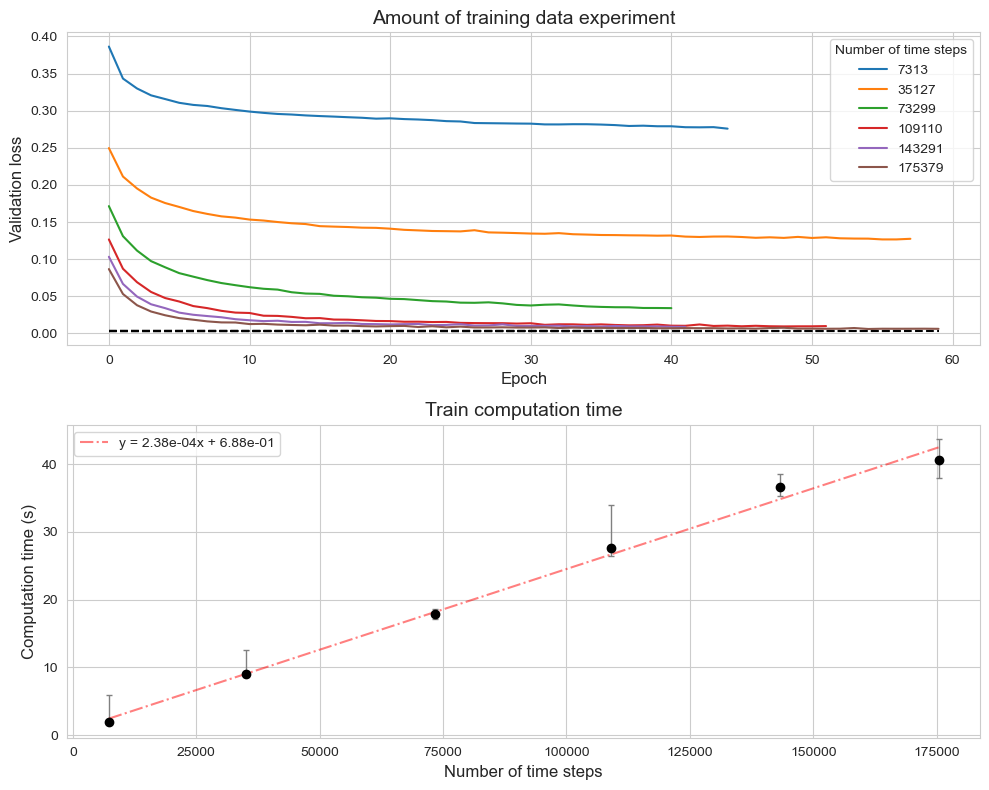

In [80]:
log_dir = '/home/lrvnc/Projects/worm-graph/logs/hydra/2023_08_14_19_07_47'
exp_name = 'num_time_steps'

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.set_style('whitegrid')

# Store computation time and parameters
computation_time = []
parameters = []

# Loop over all the experiment files
for file in np.sort(os.listdir(log_dir)):

    # Skip if not starts with exp
    if not file.startswith('exp') and not file.startswith('exp_'):
        continue

    # Get experiment directory
    exp_dir = os.path.join(log_dir, file)
    
    # Load train metrics
    df = pd.read_csv(os.path.join(exp_dir, 'train', 'train_metrics.csv'))

    # Experiment parameters
    exp_param, exp_title, exp_xaxis = experiment_parameter(exp_dir, key=exp_name)
    ct_param, ct_title, ct_xaxis = experiment_parameter(exp_dir, key='computation_time')

    # Store computation time and parameters
    computation_time.append(ct_param)
    parameters.append(exp_param)

    # Plot validation loss
    ax[0].plot(df['epoch'], df['val_loss'], label=exp_param)
    # Plot validation baseline
    ax[0].plot(df['epoch'], df['val_baseline'], color='black', linestyle='--')

# Set loss labels
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Validation loss', fontsize=12)

# Set loss legend
legend = ax[0].legend(fontsize=10)
legend.set_title(exp_xaxis)

# Set loss title
ax[0].set_title(exp_title + ' experiment', fontsize=14)

# Plot computation time with error bars
y = np.array(computation_time)[:,1].T # mean
yerr = np.array(computation_time)[:,::2].T # min max variation
yerr[0,:] = y - yerr[0,:]
yerr[1,:] = yerr[1,:] - y
ax[1].errorbar(parameters, y, yerr=yerr, fmt='o', capsize=2, ecolor='grey', color='black', elinewidth=1)

# Regression line computation time
slope, intercept, r_value, p_value, std_err = stats.linregress(parameters, y)
x = np.linspace(np.min(parameters), np.max(parameters), 100)
ct_reg_label = 'y = {:.2e}x + {:.2e}'.format(slope, intercept)
ax[1].plot(x, intercept + slope*x, color='red', linestyle='-.', alpha=0.5, label=ct_reg_label)

# Set computation time labels
ax[1].set_xlabel(exp_xaxis, fontsize=12)
ax[1].set_ylabel('Computation time (s)', fontsize=12)

# Set computation time title
ax[1].set_title(ct_title, fontsize=14)

# Set computation time legend
legend = ax[1].legend(fontsize=10)

plt.tight_layout()

# Save figure
#fig.savefig(os.path.join(log_dir, 'val_loss.png'))

# Show figure
plt.show()

## Scaling law
---

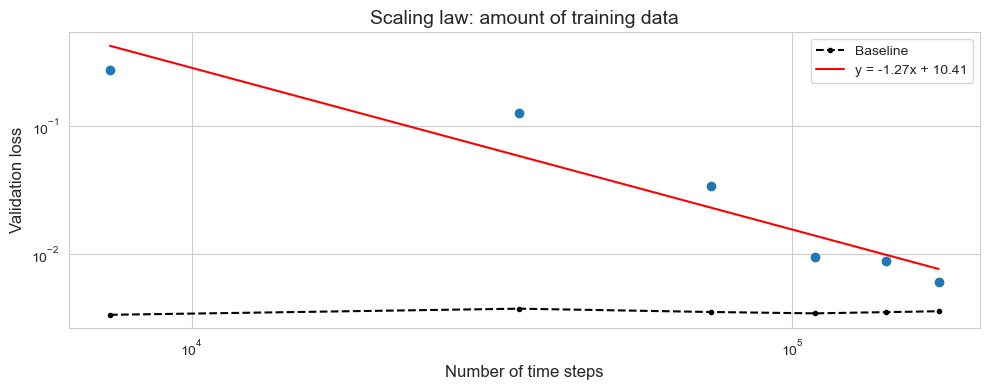

In [14]:
log_dir = '/home/lrvnc/Projects/worm-graph/logs/hydra/2023_08_14_19_07_47'
exp_name = 'num_time_steps'

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Store losses, parameter experiment and baselines
losses = []
exp_parameter = []
baselines = []

# Loop over all the experiment files
for file in np.sort(os.listdir(log_dir)):

    # Skip if not starts with exp
    if not file.startswith('exp') and not file.startswith('exp_'):
        continue

    # Get experiment directory
    exp_dir = os.path.join(log_dir, file)
    
    # Load train metrics
    df = pd.read_csv(os.path.join(exp_dir, 'train', 'train_metrics.csv'))

    # Lower validation loss
    losses.append(df['val_loss'].min())
    baselines.append(df['val_baseline'].mean())

    # Get experiment parameter
    exp_param, exp_title, xaxis_title = experiment_parameter(exp_dir, key=exp_name)
    exp_parameter.append(exp_param)

# Plot
ax.plot(exp_parameter, losses, 'o')
ax.plot(exp_parameter, baselines, '--.', color='black', label='Baseline')
ax.set_xlabel(xaxis_title, fontsize=12)
ax.set_ylabel('Validation loss', fontsize=12)

# Log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(exp_parameter), np.log(losses))
fit_label = 'y = {:.2f}x + {:.2f}'.format(slope, intercept)
ax.plot(exp_parameter, np.exp(intercept + slope * np.log(exp_parameter)), 'r', label=fit_label)

# Legend
ax.legend(fontsize=10)

# Title
ax.set_title('Scaling law: ' + exp_title.lower(), fontsize=14)

plt.tight_layout()

# Save
#plt.savefig(os.path.join(log_dir, 'plots', 'scaling_law_' + exp_name + '.png'), dpi=300)

plt.show()

# Comparing Experiments
---

In [17]:
from visualize._utils import plot_scaling_law
from visualize._utils import experiment_parameter
import itertools

NeuralTransformer
LinearNN
NetworkLSTM


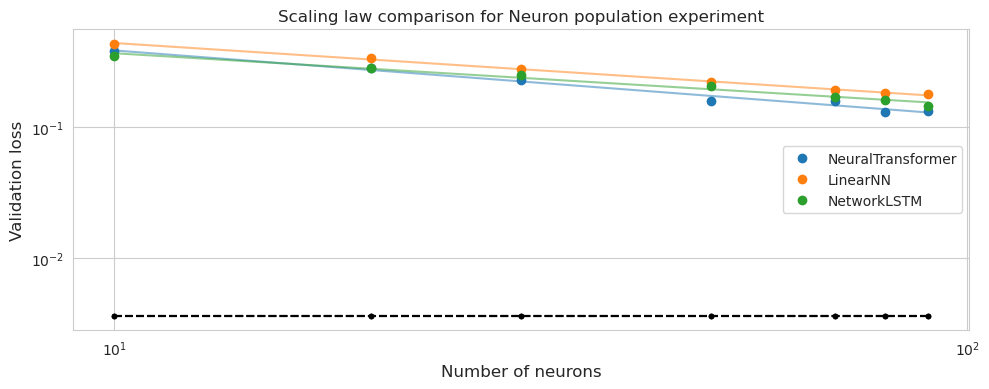

In [30]:
exp_key = 'num_named_neurons'
comparison_param_key = 'model_type'
exp_log_dirs = [
    '/om2/user/lrvenan/worm-graph/logs/hydra/NNN_TRANSFORMER_08_17',
    '/om2/user/lrvenan/worm-graph/logs/hydra/NNN_LINEAR_08_17',
    '/om2/user/lrvenan/worm-graph/logs/hydra/NNN_LSTM_08_17',
]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.set_style("whitegrid")
sns.set_palette("tab10")
palette = sns.color_palette("tab10")
color_cycle = itertools.cycle(palette)

for exp_log_dir in exp_log_dirs:
    comparison_param, _, _ = experiment_parameter(os.path.join(exp_log_dir, 'exp0'), key=comparison_param_key)
    print(comparison_param)
    fig, ax = plot_scaling_law(exp_log_dir=exp_log_dir, exp_name=exp_key, exp_plot_dir=None, fig=fig, ax=ax)
    # Change label using comparison_param
    ax.lines[-3].set_label(comparison_param)
    # Change reg. line color
    ax.lines[-1].set_color(next(color_cycle))
    # Change reg. line alpha
    ax.lines[-1].set_alpha(0.5)
    # Remove reg. line label
    ax.lines[-1].set_label(None)
    # Remove baseline line label
    ax.lines[-2].set_label(None)

# Update title
_, exp_title, _ = experiment_parameter(os.path.join(exp_log_dir, 'exp0'), key=exp_key)
ax.set_title(f"Scaling law comparison for {exp_title} experiment")

# Update figure and display
ax.legend()
fig.tight_layout()
fig.show()